In [2]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from pathlib import Path
import yaml

## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):

    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
        nb_cwd.parents[1]                    # -> git/trend_following
        / "live_strategy"
        / f"trend_following_strategy_{strategy_version}-live"
        / "config"
        / f"trend_strategy_config_{strategy_version}.yaml"
    )
    
    print(config_path)            # sanity check
    print(config_path.exists())   # should be True
    
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
## Load Total Portfolio Equity and Available Cash
def get_live_portfolio_equity_and_cash(client, portfolio_name='Default'):

    ## Get Portfolio UUID and Positions
    portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name)
    df_portfolio_positions = cn.get_portfolio_breakdown(client, portfolio_uuid)

    ## Get Portfolio Value and Available Cash
    cash_cond = (df_portfolio_positions.is_cash == True)
    portfolio_equity = float(df_portfolio_positions[~cash_cond]['total_balance_fiat'].sum())
    available_cash = float(df_portfolio_positions[cash_cond]['available_to_trade_fiat'].sum())

    return portfolio_equity, available_cash

In [7]:
## Pull Live Prices for each ticker in the portfolio
def get_price_map(client, ticker_list):
    result_dict = {}
    for ticker in ticker_list:
        ## Get Best Bid and Offer Data
        book = client.get_product_book(ticker, limit=1)['pricebook']
    
        ## Build Price Dictionary
        price_dict = {'best_bid_price': float(book['bids'][0]['price']),
                      'best_bid_size': float(book['bids'][0]['size']),
                      'best_ask_price': float(book['asks'][0]['price']),
                      'best_ask_size': float(book['asks'][0]['size']),
                      'best_mid_price': (float(book['bids'][0]['price']) + float(book['asks'][0]['price'])) / 2}
    
        result_dict[ticker] = price_dict

    return result_dict

In [14]:
## Live Positions in the portfolio
def get_current_positions_from_portfolio(client, ticker_list, portfolio_name='Default'):

    df_portfolio = cn.get_portfolio_breakdown(client, portfolio_uuid=cn.get_portfolio_uuid(client, portfolio_name))
    price_map = get_price_map(client, ticker_list)

    ticker_result = {}
    for ticker in ticker_list:
        ticker_cond = (df_portfolio['asset'] == ticker[:-4])
        if df_portfolio[ticker_cond].shape[0] > 0:
            ticker_qty = float(df_portfolio[ticker_cond]['total_balance_crypto'])
        else:
            ticker_qty = 0
        ticker_mid_price = float(price_map[ticker]['best_mid_price'])
        ticker_result[ticker] = {'ticker_qty': ticker_qty,
                                 'ticker_mid_price': ticker_mid_price,
                                 'ticker_current_notional': ticker_qty * ticker_mid_price}

    return ticker_result

In [16]:
## Generate weighted and scaled final signal
def get_strategy_trend_signal(cfg):

    end_date = datetime.now(timezone.utc).date()
    start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

    # Build kwargs directly from cfg sections
    sig_kwargs = {
        # Dates
        "start_date": start_date,
        "end_date": end_date,

        # Universe
        "ticker_list": cfg["universe"]["tickers"],

        # Moving Average Signal
        "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
        "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
        "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
        "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

        # Donchain Channel Signal
        "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
        "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
        "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

        # Signal Weights
        "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
        "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
        "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
        "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

        # Rolling R Squared Filter
        "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
        "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
        "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
        "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

        # Vol of Vol Filter
        "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
        "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
        "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
        "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
        "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

        # Signal & Data Parameters
        "use_activation": cfg["signals"]["activation"]["use_activation"],
        "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
        "moving_avg_type": cfg["data"]["moving_avg_type"],
        "long_only": cfg["run"]["long_only"],
        "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
        "use_coinbase_data": cfg["data"]["use_coinbase_data"],
        "use_saved_files": False,
        "saved_file_end_date": cfg["data"]["saved_file_end_date"]
    }
    
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(**sig_kwargs)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list=cfg['universe']['tickers'],
                                                                          volatility_window=cfg['risk_and_sizing']['volatility_window'],
                                                                          annual_trading_days=cfg['run']['annual_trading_days'])

    # print('Getting Average True Range for Stop Loss Calculation!!')
    # ## Get Average True Range for Stop Loss Calculation
    # atr_kwargs = {
    #     # dates
    #     "start_date": start_date,
    #     "end_date": end_date,
        
    #     # run / universe / data
    #     "ticker_list": cfg["universe"]["tickers"],
    
    #     # risk and sizing
    #     "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    
    #     # data
    #     "price_or_returns_calc": cfg['data']['price_or_returns_calc'],
    #     "use_coinbase_data": cfg['data']['use_coinbase_data'],
    #     "use_saved_files": False,
    #     "saved_file_end_date": cfg['data']['saved_file_end_date']
    # }
    # df_atr = size_cont.get_average_true_range_portfolio(**atr_kwargs)
    # df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    return df_signal

In [18]:
## Generate Target Notionals and Daily Trades
def get_target_notional_by_ticker(df, date, ticker_list, initial_capital, rolling_cov_window,
                                  rolling_atr_window, atr_multiplier, cash_buffer_percentage,
                                  annualized_target_volatility, transaction_cost_est=0.001,
                                  passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                  min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                  annual_trading_days=365, use_specific_start_date=False,
                                  signal_start_date=None, portfolio_name='Default'):
    ## Create Coinbase Client & Portfolio UUID
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
    portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)

    ## Get Live Portfolio Equity
    portfolio_equity, available_cash = get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)

    ## Get Portfolio Breakdown
    df_portfolio_breakdown = cn.get_portfolio_breakdown(client, portfolio_uuid=portfolio_uuid)

    ## Get Current Positions using Mid-Price
    ## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
    current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                             portfolio_name=portfolio_name)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index.get_level_values(0).min()
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_cash_shrink_factor'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['cash_shrink_factor'] = 1.0
    df['final_scaling_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date:
        start_index_position = df.index.get_loc(signal_start_date)
    else:
        start_index_position = 0
    # df['available_cash'][start_index_position] = initial_capital
    # df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    # for date in df.index[start_index_position + 1:]:
    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Start the day with the available cash from portfolio
    df['available_cash'].loc[date] = available_cash  # df['available_cash'].loc[previous_date]

    ## Calculate Total Portfolio Value from Portfolio Positions
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
    df['total_actual_position_notional'].loc[date] = portfolio_equity
    total_portfolio_value = (df['available_cash'].loc[date] +
                             df[short_sale_proceeds_cols].loc[date].sum() +
                             df['total_actual_position_notional'].loc[date])
    df['total_portfolio_value'].loc[date] = total_portfolio_value

    ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
    total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                         (1 - cash_buffer_percentage))
    df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

    ## Calculate the target notional by ticker
    df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                         total_portfolio_value_upper_limit)

    ## Adjust Positions for Cash Available
    desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
        df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
        total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

    ## Apply Cash Shrink Factor to Desired Positions
    for ticker in ticker_list:
        desired_positions[ticker]['new_trade_notional'] = desired_positions[ticker][
                                                              'new_trade_notional'] * cash_shrink_factor
        desired_positions[ticker]['trade_fees'] = desired_positions[ticker]['trade_fees'] * cash_shrink_factor

    return df, desired_positions, cash_shrink_factor

In [33]:
def calculate_average_true_range_live(date, ticker, rolling_atr_window=20):

    end_date = date
    start_date = date - pd.Timedelta(days=(rolling_atr_window + 200))
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=date, save_to_file=False)
    df.columns = [f'{ticker}_{x}' for x in df.columns]
    
    ## Get T-1 Close Price
    df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)

    # Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[
        [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
        span=rolling_atr_window, adjust=False).mean()

    ## Shift by 1 to avoid look-ahead bias
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[
        f'{ticker}_{rolling_atr_window}_avg_true_range_price'].shift(1)

    return df

In [20]:
def list_open_stop_orders(client, product_id):
    """
    Return a normalized list of OPEN stop/stop-limit orders for `product_id`.
    Adjust the underlying client call and field names to match your SDK.
    Output items have: order_id, client_order_id, product_id, side, type, stop_price, created_at
    """
    # 1) Fetch open orders (adapt this block to your SDK)
    try:
        # Path A: some SDKs use list_orders(product_id=..., order_status=[...])
        res = client.list_orders(product_id=product_id, order_status=['OPEN'])
        raw = res['orders']
    except Exception:
        raw = []

    # 2) Normalize & filter only stops
    orders = []
    for o in raw:
        otype      = o['order_type'].lower()
        stop_price = o['stop_price'] or o['stopPrice']
        if ('stop' in otype) or (stop_price is not None):
            orders.append({
                'order_id'       : o['order_id'] or o['id'],
                'client_order_id': o['client_order_id'] or o['clientOrderId'],
                'product_id'     : o['product_id'] or o['productId'] or product_id,
                'side'           : o['side'],
                'type'           : o['order_type'] or o['type'],
                'stop_price'     : float(stop_price) if stop_price is not None else np.nan,
                'created_at'     : o['created_time'] or o['created_at'],
            })
    return orders

def get_open_stop_price(client, product_id, client_id_prefix="stop-"):
    """
    Return the highest stop_price among your currently-open stops for `product_id`,
    optionally filtered by your client_order_id prefix. NaN if none.
    """
    try:
        open_stops = list_open_stop_orders(client, product_id) or []
    except Exception:
        open_stops = []

    prices = []
    for order in open_stops:
        clordid = str(order['client_order_id'] or '')
        if (client_id_prefix is None) or clordid.startswith(f"{client_id_prefix}{product_id}-"):
            stop_price = order['stop_price']
            if stop_price is not None and np.isfinite(stop_price):
                prices.append(float(stop_price))
    return max(prices) if prices else np.nan


In [22]:
def chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier):
    
    ## Get Average True Range
    df_atr = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)
    atr = df_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date]

    ## Get the Highest High from previous date
    highest_high_t_1 = df_atr[f'{ticker}_high'].rolling(highest_high_window).max().shift(1)
    chandelier_stop = highest_high_t_1 - atr_multiplier * atr
    chandelier_stop = chandelier_stop.loc[date]
    
    return chandelier_stop

In [75]:
# --- Config & Prep -----------------------------------------------------------
## Strategy Parameters
cfg = load_prod_strategy_config()
date = datetime.now(timezone.utc).date()
# portfolio_name = 'Default'
portfolio_name = cfg['portfolio']['name']

## Strategy Inputs
ticker_list = cfg['universe']['tickers']
initial_capital = cfg['run']['initial_capital']
rolling_cov_window = cfg['risk_and_sizing']['rolling_cov_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
cash_buffer_percentage = cfg['risk_and_sizing']['cash_buffer_percentage']
annualized_target_volatility = cfg['risk_and_sizing']['annualized_target_volatility']
transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
notional_threshold_pct = cfg['execution_and_costs']['notional_threshold_pct']
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']
annual_trading_days = cfg['run']['annual_trading_days']
use_specific_start_date = False
signal_start_date = cfg['run']['signal_start_date']
portfolio_name = portfolio_name


# --- Helpers ----------------------------------------------------------------
def _long_stop_for_today(ticker):
    """Chandelier stop (long) for *today*, computed from live ATR & T-1 highest high."""
    return float(chandelier_stop_long(
        date=date,
        ticker=ticker,
        highest_high_window=highest_high_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier
    ))

def _entry_allowed_long(curr_price, stop_today, eps=0.0):
    """
    Gate for NEW/ADDED long risk:
    - allow only if current price is strictly above today's stop (plus optional eps).
    """
    return np.isfinite(curr_price) and np.isfinite(stop_today) and (curr_price > stop_today * (1 + eps))


# --- 1) Build signal DF & covariance ----------------------------------------
## Generate Strategy Signal from T-1 Data
df_signal = get_strategy_trend_signal(cfg)
df = df_signal

## Get Target Notionals by Ticker in Universe
print(f'Covariance Matrix Time: {datetime.now()}')
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

## Delete rows prior to the first available date of the covariance matrix
cov_matrix_start_date = cov_matrix.index.get_level_values(0).min()
df = df[df.index >= cov_matrix_start_date]


# --- 2) Live portfolio state -------------------------------------------------
## Get Portfolio Positions and Cash
print(f'Start Time: {datetime.now()}')
## Create Coinbase Client & Portfolio UUID
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)

print(f'Get Portfolio Equity and Cash Time: {datetime.now()}')
## Get Live Portfolio Equity
portfolio_equity, available_cash = get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)

print(f'Get Portfolio Position Breakdown Time: {datetime.now()}')
## Get Portfolio Breakdown
df_portfolio_breakdown = cn.get_portfolio_breakdown(client, portfolio_uuid=portfolio_uuid)

print(f'Get Current Positions Time: {datetime.now()}')
## Get Current Positions using Mid-Price
## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list, portfolio_name=portfolio_name)

## Identify Daily Positions starting from day 2
previous_date = df.index[df.index.get_loc(date) - 1]

## Reorder dataframe columns
for ticker in ticker_list:
    df[f'{ticker}_new_position_size'] = 0.0
    df[f'{ticker}_new_position_notional'] = 0.0
    df[f'{ticker}_open_position_size'] = 0.0
    df[f'{ticker}_open_position_notional'] = 0.0
    df[f'{ticker}_actual_position_size'] = 0.0
    df[f'{ticker}_actual_position_notional'] = 0.0
    df[f'{ticker}_short_sale_proceeds'] = 0.0
    df[f'{ticker}_new_position_entry_exit_price'] = 0.0
    df[f'{ticker}_target_vol_normalized_weight'] = 0.0
    df[f'{ticker}_target_notional'] = 0.0
    df[f'{ticker}_target_size'] = 0.0
    df[f'{ticker}_cash_shrink_factor'] = 0.0
    df[f'{ticker}_stop_loss'] = 0.0
    df[f'{ticker}_stopout_flag'] = False
    df[f'{ticker}_cooldown_counter'] = 0.0
    df[f'{ticker}_event'] = np.nan
ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
df = df[ord_cols]

## Portfolio Level Cash and Positions are all set to 0
df['daily_portfolio_volatility'] = 0.0
df['available_cash'] = 0.0
df['count_of_positions'] = 0.0
df['total_actual_position_notional'] = 0.0
df['total_target_notional'] = 0.0
df['total_portfolio_value'] = 0.0
df['total_portfolio_value_upper_limit'] = 0.0
df['target_vol_scaling_factor'] = 1.0
df['cash_scaling_factor'] = 1.0
df['cash_shrink_factor'] = 1.0
df['final_scaling_factor'] = 1.0

## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
if use_specific_start_date:
    start_index_position = df.index.get_loc(signal_start_date)
else:
    start_index_position = 0
# df['available_cash'][start_index_position] = initial_capital
# df['total_portfolio_value'][start_index_position] = initial_capital

# Seed state (+ carry over T-1 actuals, open notionals, and any existing stop levels)
## Assign Live Cash and Positions
for ticker in ticker_list:
    # Actuals as of T-1
    df[f'{ticker}_actual_position_notional'].loc[previous_date] = current_positions[ticker]['ticker_current_notional']
    df[f'{ticker}_actual_position_size'].loc[previous_date] = current_positions[ticker]['ticker_qty']
    
    # Open Positions at T
    df[f'{ticker}_open_position_notional'].loc[date] = current_positions[ticker]['ticker_current_notional']
    df[f'{ticker}_open_position_size'].loc[date] = current_positions[ticker]['ticker_qty']

    # Carry Forward any Open Stop Loss Positions from T-1
    open_stop_loss = get_open_stop_price(client, product_id=ticker, client_id_prefix='stop-')
    df[f'{ticker}_stop_loss'].loc[previous_date] = np.where(pd.isna(open_stop_loss), 0.0, open_stop_loss).item()

## Portfolio Aggregates for today
# Update Available Cash based on cash in Coinbase portfolio
df['available_cash'].loc[date] = available_cash

# Calculate Total Portfolio Value from Portfolio Positions
short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
open_position_notional_cols = [f'{ticker}_open_position_notional' for ticker in ticker_list]
df['total_actual_position_notional'].loc[date] = df[open_position_notional_cols].loc[date].sum()
total_portfolio_value = (df['available_cash'].loc[date] +
                         df[short_sale_proceeds_cols].loc[date].sum() +
                         df['total_actual_position_notional'].loc[date])
df['total_portfolio_value'].loc[date] = total_portfolio_value

# Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                     (1 - cash_buffer_percentage))
df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit


# --- 3) Target notionals via target-vol sizing -------------------------------
print(f'Target Volatility Position Sizing Time: {datetime.now()}')

## Derive the Daily Target Portfolio Volatility
daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

## Calculate the target notional by ticker
df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                     total_portfolio_value_upper_limit)


# --- 4) Build desired trades with STOP-GATE for new/added longs --------------
## Get Desired Trades based on Target Notionals and Current Notional Values by Ticker
desired_positions = {}
cash_debit = 0.0  # buys + fees
cash_credit = 0.0  # sells - fees
available_cash = df['available_cash'].loc[date] * (1 - cash_buffer_percentage)

## Estimated Transaction Costs and Fees
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

for ticker in ticker_list:
    ## Calculate the cash need from all new target positions
    target_notional = df[f'{ticker}_target_notional'].loc[date]
    current_notional = df[f'{ticker}_open_position_notional'].loc[date]
    new_trade_notional = target_notional - current_notional
    trade_fees = abs(new_trade_notional) * est_fees
    mid_px = float(current_positions[ticker]['ticker_mid_price'])

    ## Calculate notional difference to determine if a trade is warranted
    portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
    notional_threshold = notional_threshold_pct * abs(target_notional)
    notional_floors_list = [
        portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
    ]
    notional_floor = max(notional_floors_list)

    # --- STOP-GATE: block NEW/ADDED long exposure if stop is breached/invalid ---
    # We only gate when the delta adds long dollar risk (delta > 0).
    if new_trade_notional > 0:
        stop_today = _long_stop_for_today(ticker)
        print(f'Ticker: {ticker}, Ticker Mid Price: {mid_px}, Stop Loss Price: {stop_today}')
        if not _entry_allowed_long(curr_price=mid_px, stop_today=stop_today, eps=0.0):
            # Block the buy; keep delta at zero but still record the stop for transparency.
            df.loc[date, f'{ticker}_stopout_flag'] = True
            df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
            desired_positions[ticker] = {'new_trade_notional': 0.0,
                                         'trade_fees': 0.0,
                                         'reason': 'stop_breached'}
            continue
        else:
            df.loc[date, f'{ticker}_stopout_flag'] = False
            df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
    # For sells or flat, we don’t block: let risk come off if needed.
    
    if abs(new_trade_notional) > notional_floor:
        desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                     'trade_fees': trade_fees}
    else:
        desired_positions[ticker] = {'new_trade_notional': 0,
                                     'trade_fees': 0}

    if new_trade_notional >= 0:
        ## Buys
        cash_debit = cash_debit + new_trade_notional
    else:
        ## Sells
        net_trade_notional = new_trade_notional + trade_fees
        cash_credit = cash_credit + abs(net_trade_notional)

## Calculate Cash Shrink Factor for the portfolio for the day
net_cash_need = cash_debit - cash_credit
if net_cash_need > available_cash + 1e-6:
    cash_shrink_factor = available_cash / net_cash_need  # 0 < shrink < 1
else:
    cash_shrink_factor = 1.0

df[f'cash_shrink_factor'].loc[date] = cash_shrink_factor

## Apply Cash Shrink Factor to Desired Positions for Buys Only
for ticker in ticker_list:
    if desired_positions[ticker]['new_trade_notional'] > 0:
        desired_positions[ticker]['new_trade_notional'] = desired_positions[ticker]['new_trade_notional'] * cash_shrink_factor
        desired_positions[ticker]['trade_fees'] = desired_positions[ticker]['trade_fees'] * cash_shrink_factor

    df[f'{ticker}_new_position_notional'].loc[date] = desired_positions[ticker]['new_trade_notional']
    df[f'{ticker}_new_position_size'].loc[date] = desired_positions[ticker]['new_trade_notional'] / current_positions[ticker]['ticker_mid_price']
    df[f'{ticker}_actual_position_notional'].loc[date] = df[f'{ticker}_new_position_notional'].loc[date] + df[f'{ticker}_open_position_notional'].loc[date]
    df[f'{ticker}_actual_position_size'].loc[date] = df[f'{ticker}_actual_position_notional'].loc[date] / current_positions[ticker]['ticker_mid_price']    

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True
Generating Volatility Adjusted Trend Signal!!
Covariance Matrix Time: 2025-10-09 22:49:16.730995
Start Time: 2025-10-09 22:49:16.739490
Get Portfolio Equity and Cash Time: 2025-10-09 22:49:16.933442
Get Portfolio Position Breakdown Time: 2025-10-09 22:49:17.199379
Get Current Positions Time: 2025-10-09 22:49:17.296937
Target Volatility Position Sizing Time: 2025-10-09 22:49:18.488992
Ticker: ETH-USD, Ticker Mid Price: 4368.4, Stop Loss Price: 4619.50378931582
Ticker: SOL-USD, Ticker Mid Price: 220.64499999999998, Stop Loss Price: 232.3316184848136
Ticker: ADA-USD, Ticker Mid Price: 0.81425, Stop Loss Price: 0.9088399090670425
Ticker: AVAX-USD, Ticker Mid Price: 28.355, Stop Loss Price: 32.85440350238216


In [35]:
stop_today = _long_stop_for_today(ticker='BTC-USD')

In [37]:
stop_today

120889.40002649091

In [43]:
current_positions[ticker]['ticker_mid_price']

{'ticker_qty': 0,
 'ticker_mid_price': 121535.055,
 'ticker_current_notional': 0.0}

In [49]:
df.tail()

,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_cash_shrink_factor,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_cash_shrink_factor,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_cash_shrink_factor,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_cash_shrink_factor,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_cash_shrink_factor,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,cash_shrink_factor,final_scaling_factor
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-10-06,0.0,0.0,0.276285,0.0,124720.09,0.0,NaN,0.0,-0.268159,0.0,0.0,0.0,123520.80,0.0,0.0,0.0,0.0,False,123520.79,0.008674,0.0,0.0,0.0,0.0,0.0,0.0,0.502705,0.0,4686.32,0.0,NaN,0.046853,0.098113,0.0,0.0,0.0,4515.40,0.0,0.0,0.0,0.000000,False,4515.40,0.005655,0.000000,0.000000,0.000000,0.093201,0.0,0.0,0.692592,0.0,232.45,0.0,NaN,0.272450,0.360765,0.0,0.0,0.0,228.68,0.0,0.0,0.0,0.000000,False,228.68,0.003158,0.000000,0.000000,0

In [67]:
stop_loss_cols = [f'{ticker}_stop_loss' for ticker in cfg['universe']['tickers']]
df[stop_loss_cols].tail(5)

,BTC-USD_stop_loss,ETH-USD_stop_loss,SOL-USD_stop_loss,ADA-USD_stop_loss,AVAX-USD_stop_loss
date,,,,,
2025-10-06,0.0,0.000000,0.000000,0.00000,0.000000
2025-10-07,0.0,0.000000,0.000000,0.00000,0.000000
2025-10-08,0.0,0.000000,0.000000,0.00000,0.000000
2025-10-09,0.0,0.000000,0.000000,0.00000,0.000000
2025-10-10,0.0,4619.503789,232.331618,0.90884,32.854404


In [51]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
df[signal_cols].tail(20)

,BTC-USD_final_signal,ETH-USD_final_signal,SOL-USD_final_signal,ADA-USD_final_signal,AVAX-USD_final_signal
date,,,,,
2025-09-21,0.0,0.273037,0.422596,0.207304,0.307821
2025-09-22,0.0,0.261720,0.424068,0.206849,0.320522
2025-09-23,0.0,0.240035,0.413098,0.194065,0.331664
2025-09-24,0.0,0.217625,0.399106,0.176293,0.340076
2025-09-25,0.0,0.195857,0.385340,0.159658,0.343845
2025-09-26,0.0,0.164678,0.357318,0.132630,0.226512
2025-09-27,0.0,0.141196,0.339448,0.113117,0.159646
2025-09-28,0.0,0.118671,0.320664,0.092666,0.215380
2025-09-29,0.0,0.101209,0.306157,0.077391,0.307184


<Axes: xlabel='date'>

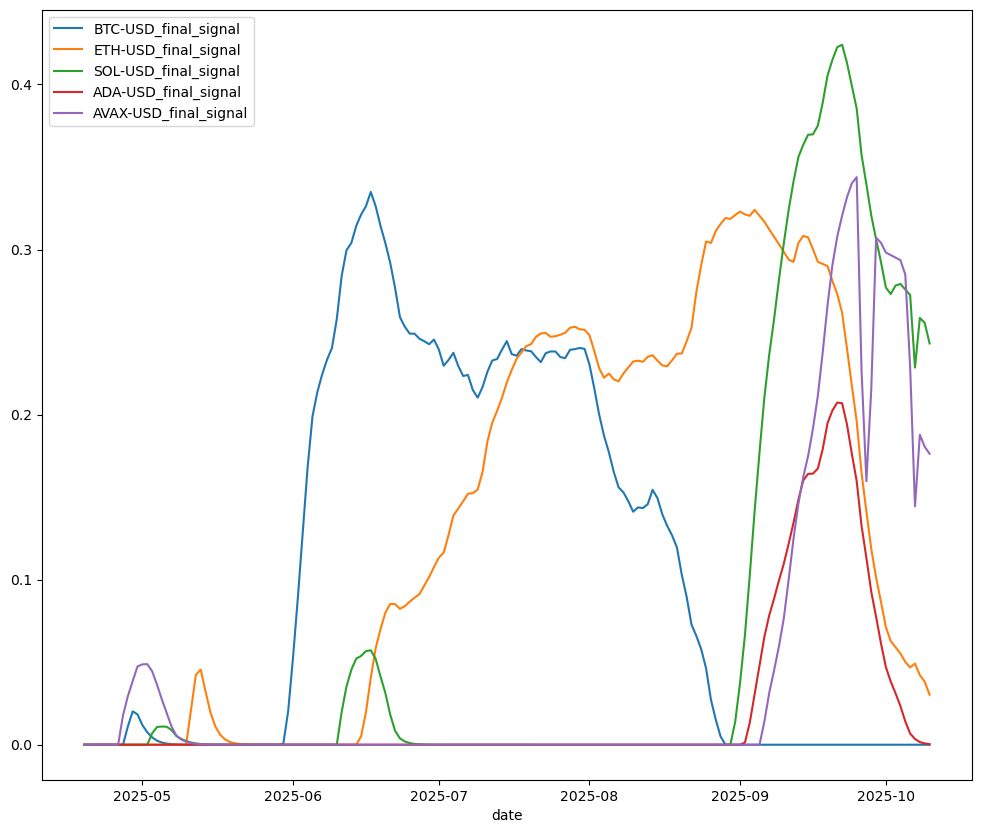

In [53]:
df[signal_cols].plot(figsize=(12,10))

In [55]:
def build_rebalance_orders(desired_positions, date, current_positions):
    """
    Build market orders for new trades. You may switch to limit orders.
    Returns a list of dicts: {product_id, side, type, size, client_order_id}
    """
    orders = []
    for t, d in desired_positions.items():
        notional = float(d.get("new_trade_notional", 0.0))
        if abs(notional) < 1e-9:
            continue
        side = 'buy' if notional > 0 else 'sell'
        px = current_positions[t]['ticker_mid_price']#price_lookup(t)
        if not (np.isfinite(px) and px > 0):
            continue
        size = abs(notional) / px
        # TODO: round to base_increment, enforce min_size/min_notional using your product specs
        orders.append({
            "product_id": t,
            "side": side,
            "type": "market",
            "size": size,
            "client_order_id": f"{t}-{date}-rebalance-{int(round(abs(notional)))}"
        })
    return orders

In [57]:
build_rebalance_orders(desired_positions, date, current_positions)

[]

In [59]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 121443.265,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 4381.955,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 221.765,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.8173,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 28.475,
  'ticker_current_notional': 0.0}}

In [61]:
desired_positions

{'BTC-USD': {'new_trade_notional': 0, 'trade_fees': 0},
 'ETH-USD': {'new_trade_notional': 0.0,
  'trade_fees': 0.0,
  'reason': 'stop_breached'},
 'SOL-USD': {'new_trade_notional': 0.0,
  'trade_fees': 0.0,
  'reason': 'stop_breached'},
 'ADA-USD': {'new_trade_notional': 0.0,
  'trade_fees': 0.0,
  'reason': 'stop_breached'},
 'AVAX-USD': {'new_trade_notional': 0.0,
  'trade_fees': 0.0,
  'reason': 'stop_breached'}}

In [63]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df[target_notional_cols].tail()

,BTC-USD_target_notional,ETH-USD_target_notional,SOL-USD_target_notional,ADA-USD_target_notional,AVAX-USD_target_notional
date,,,,,
2025-10-06,0.0,0.000000,0.000000,0.000000,0.000000
2025-10-07,0.0,0.000000,0.000000,0.000000,0.000000
2025-10-08,0.0,0.000000,0.000000,0.000000,0.000000
2025-10-09,0.0,0.000000,0.000000,0.000000,0.000000
2025-10-10,0.0,51.264885,321.374751,0.550499,185.741626


In [122]:
## TODO: CANCEL AND OPEN STOP LOSS ORDERS ONCE ORDERS ARE CANCELLED
def should_close_dust(df, date, actual_notional, min_notional_abs, pct_of_portfolio=0.002):
    total_portfolio_value = float(df.loc[date, 'total_portfolio_value'])
    return (abs(actual_notional) < float(min_notional_abs)) or (abs(actual_notional) < pct_of_portfolio * total_portfolio_value)
    
def build_dust_close_orders(df, date, ticker_list, min_trade_notional_abs):
    """
    Flatten tiny residual positions to zero.
    """
    orders = []
    for t in ticker_list:
        actual_notional = float(df.loc[date, f'{t}_actual_position_notional'])
        if should_close_dust(df, date, actual_notional, min_trade_notional_abs):
            size_now = float(df.loc[date, f'{t}_actual_position_size'])
            if abs(size_now) < 1e-12:
                continue
            side = 'sell' if size_now > 0 else 'buy'
            orders.append({
                "product_id": t,
                "side": side,
                "type": "market",
                "size": abs(size_now),
                "client_order_id": f"{t}-{date}-dustclose-{int(round(abs(actual_notional)))}"
            })
            # reflect flatten in df
            df.loc[date, f'{t}_actual_position_notional'] = 0.0
            df.loc[date, f'{t}_actual_position_size'] = 0.0
    return orders

In [124]:
should_close_dust(df, date, actual_notional=43.4995522227813, min_notional_abs=10, pct_of_portfolio=0.002)

False

In [126]:
build_dust_close_orders(df, date, ticker_list, min_trade_notional_abs)

[]

In [128]:
min_trade_notional_abs

10

In [92]:
import math
from decimal import Decimal

# your helper
def round_to_increment(x, step):
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))

def _round_down(x, step):  # uses your function for final precision
    return round_to_increment(math.floor(x / step) * step, step)

def _round_up(x, step):
    return round_to_increment(math.ceil(x / step) * step, step)

def place_stop_limit_order(
    client,
    product_id,
    side,
    stop_price,
    size,
    client_order_id,
    *,
    buffer_bps=50,
    preview=False,
    price_increment=0.01,
    base_increment=1e-8,
    quote_min_size=None
):
    """
    Stop-LIMIT (emulates stop-market with buffer) using your round_to_increment.
      SELL (long protection): limit = stop * (1 - buffer), stop ↑, limit ↓
      BUY  (short protection): limit = stop * (1 + buffer), stop ↓, limit ↑
    """
    side = side.upper()
    buf = float(buffer_bps) / 10_000.0

    # Directional rounding for prices
    if side == "SELL":
        sp = _round_up(float(stop_price), float(price_increment))
        lp = _round_down(sp * (1.0 - buf), float(price_increment))
        stop_dir = "STOP_DIRECTION_STOP_DOWN"
    elif side == "BUY":
        sp = _round_down(float(stop_price), float(price_increment))
        lp = _round_up(sp * (1.0 + buf), float(price_increment))
        stop_dir = "STOP_DIRECTION_STOP_UP"
    else:
        raise ValueError("side must be 'BUY' or 'SELL'")

    # Base size rounding (↓) and optional min notional enforcement
    sz = _round_down(float(size), float(base_increment))
    if quote_min_size:
        # ensure price*size >= quote_min_size
        if sp * sz < float(quote_min_size):
            needed = float(quote_min_size) / sp
            # bump up, then round down to base_increment (to avoid exceeding increments)
            sz = _round_down(needed, float(base_increment))

    order_configuration = {
        "stop_limit_stop_limit_gtc": {
            "base_size":     f"{sz}",
            "limit_price":   f"{lp}",
            "stop_price":    f"{sp}",
            "stop_direction": stop_dir,
        }
    }

    if preview:
        # NOTE: preview must NOT include client_order_id
        return client.preview_order(
            product_id=product_id,
            side=side,
            order_configuration=order_configuration,
        )

    # # Live placement: include client_order_id
    # return client.create_order(
    #     client_order_id=client_order_id,
    #     product_id=product_id,
    #     side=side,
    #     order_configuration=order_configuration,
    # )


In [130]:
def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))


import math, time, uuid
from typing import Dict, Any

def get_product_meta(client, product_id: str):
    """
    Returns increments & mins for sizing/price rounding.
    """
    p = client.get_product(product_id)  # Advanced Trade: /api/v3/brokerage/products/{product_id}
    # Public/List Public Products also exposes similar fields.
    # Fields include base_increment, quote_increment, base_min_size, quote_min_size, price_increment, etc.
    return {
        "base_increment": float(p.base_increment),                                                    ## Minimum amount base value can be increased or decreased at once.
        "quote_increment": float(p.quote_increment) if getattr(p, "quote_increment", None) else None, ## Minimum amount quote value can be increased or decreased at once
        "base_min_size": float(p.base_min_size),                                                      ## Minimum size that can be represented of base currency
        "quote_min_size": float(p.quote_min_size) if getattr(p, "quote_min_size", None) else None,    ## Minimum size that can be represented of quote currency
        "price_increment": float(p.price_increment) if getattr(p, "price_increment", None) else None, ## Minimum amount price can be increased or decreased at once
    }


def update_trailing_stop_chandelier(client, df, ticker, date, highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5, stop_loss_replace_threshold_ticks=1, 
                                    client_id_prefix="stop-", limit_price_buffer=0.005):

    ## Get Product Specs
    specs = get_product_meta(client, product_id=ticker)
    tick = specs['price_increment']

    ## Calculate today's stop loss based on Chandelier logic 
    stop_today = float(chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier))
    
    ## Get the max of yesterday's and today's stop loss - no ratchet logic
    stop_prev = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

    ## Pick the desired stop (monotone ratchet)
    candidates = [x for x in (stop_prev, stop_today) if np.isfinite(x)]
    desired_stop = max(candidates) if candidates else stop_today
    desired_stop = round_to_increment(desired_stop, specs.get('price_increment'))

    ## Decide to replace the stop loss: skip or replace?
    ## If we have an open stop, only replace if the new desired is meaningfully higher (>= +min_delta_ticks)
    threshold = (stop_prev if np.isfinite(stop_prev) else -np.inf) + (stop_loss_replace_threshold_ticks * tick)
    if np.isfinite(stop_prev) and desired_stop < threshold:
        # No meaningful ratchet; skip
        df.loc[date, f'{ticker}_stop_loss'] = float(stop_prev)  # persist what’s effectively active
        return {
            "action": "skip",
            "reason": "no_ratchet",
            "open_stop_price": float(stop_prev),
            "stop_today": float(stop_today),
            "desired_stop": float(desired_stop),
            "tick": float(tick)
        }
    else:
        ## Cancel existing open stops (avoid duplicates)
        try:
            open_orders = list_open_stop_orders(client, product_id=ticker)
            open_orders = np.where(pd.isna(open_orders), [], open_orders)
            for o in open_orders:
                otype = str(o['order_type']).lower()
                if ('stop' in otype) or (o['stop_price'] is not None):
                    # cn.cancel_order(client, o['order_id'])
                    print({
                        "action": "cancel",
                        "reason": "open stop loss",
                        "open_stop_price": f"{float(stop_prev)}",
                        "stop_today": f"{float(stop_today)}",
                        "desired_stop": f"{float(desired_stop)}",
                        "tick": f"{float(tick)}"
                    })
        except Exception as e:
            # Log & continue; we still attempt to place the new one
            print(f"[warn] cancel stop failed for {ticker}: {e}")

        # --- compute order params
        # Position size to protect:
        
        # Prefer your df actual size for today; otherwise query your positions wrapper
        try:
            pos_size = float(df.loc[date, f'{ticker}_actual_position_size'])
        except Exception:
            pos = (get_current_positions_from_portfolio(client, [ticker]) or {}).get(ticker, {})
            pos_size = float(pos[ticker].get('ticker_qty', 0.0))
        if pos_size <= 0:
            df.loc[date, f'{ticker}_stop_loss'] = float(desired_stop)
            return {
                "action": "skip",
                "reason": "no_position",
                "open_stop_price": float(open_stop_price) if np.isfinite(open_stop_price) else None,
                "stop_new": float(stop_new),
                "desired_stop": float(desired_stop),
                "tick": float(tick)
            }
    
        # Stop-limit buffer for sell stops (long positions)
        # limit_price = round_to_increment(desired_stop * (1 - limit_price_buffer), tick)
    
        # --- place new stop-limit
        client_order_id = f"{client_id_prefix}{ticker}-{date:%Y%m%d}-{int(round(desired_stop / tick))}"
        try:
            preview_order = place_stop_limit_order(
                client=client,
                product_id=ticker,
                side="sell",
                stop_price=desired_stop,
                # limit_price=limit_price,
                size=pos_size,
                client_order_id=client_order_id,
                buffer_bps=50,
                preview=True
            )
        except Exception as e:
            print(f"[error] place stop failed for {ticker}: {e}")
            # Still persist desired stop; next run will retry
        df.loc[date, f'{ticker}_stop_loss'] = float(desired_stop)

    return preview_order, desired_stop

In [96]:
ticker = 'ETH-USD'
update_trailing_stop_chandelier(client, df, ticker, date, highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5, stop_loss_replace_threshold_ticks=1, 
                                client_id_prefix="stop-", limit_price_buffer=0.005)

({'order_total': '', 'commission_total': '', 'errs': ['PREVIEW_STOP_PRICE_ABOVE_LAST_TRADE_PRICE'], 'warning': [], 'quote_size': '', 'base_size': '', 'best_bid': '', 'best_ask': '', 'is_max': False, 'order_margin_total': '', 'leverage': '', 'long_leverage': '', 'short_leverage': '', 'slippage': '', 'preview_id': '6a120dc6-bd03-43af-823f-da92d9f6bb9f', 'current_liquidation_buffer': '', 'projected_liquidation_buffer': '', 'max_leverage': '', 'pnl_configuration': None, 'twap_bucket_metadata': None, 'position_notional_limit': '', 'max_notional_at_requested_leverage': '', 'margin_ratio_data': None, 'commission_detail_total': None, 'scaled_metadata': None, 'compliance_limit_data': None, 'equity_order_metadata': None, 'est_average_filled_price': ''},
 4494.78)

In [ ]:
highest_high_window=56
rolling_atr_window=20
atr_multiplier=2.5

## Get Average True Range
df_atr = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)
atr = df_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date]

## Get the Highest High from previous date
highest_high_t_1 = df_atr[f'{ticker}_high'].rolling(highest_high_window).max().shift(1)
chandelier_stop = highest_high_t_1 - atr_multiplier * atr
chandelier_stop = chandelier_stop.loc[date]

In [ ]:
chandelier_stop

In [ ]:
highest_high_t_1

In [ ]:
df_atr.tail(60)

In [ ]:
desired_positions

In [ ]:
current_positions

In [ ]:
get_product_meta(client=client, product_id='AVAX-USD')

In [ ]:
df_atr.head()

In [ ]:
df.tail()

In [ ]:
specs = get_product_meta(client, product_id=ticker)
tick = specs['price_increment']
client=client,
product_id=ticker,
side="sell",
stop_price=30.06,
# limit_price=limit_price,
size=pos_size,
client_order_id = f"{client_id_prefix}{ticker}-{date:%Y%m%d}-{int(round(desired_stop / tick))}"
buffer_bps=50,
preview=True

side = side.upper()
sp = Decimal(str(stop_price))
buf = Decimal(buffer_bps) / Decimal(10_000)
sz = str(size)

if side == "SELL":
    limit_price = sp * (Decimal(1) - buf)
    stop_dir = "STOP_DIRECTION_STOP_DOWN"
elif side == "BUY":
    limit_price = sp * (Decimal(1) + buf)
    stop_dir = "STOP_DIRECTION_STOP_UP"
else:
    raise ValueError("side must be 'BUY' or 'SELL'")

payload = {
    "client_order_id": client_order_id,
    "product_id": product_id,
    "side": side,
    "order_configuration": {
        "stop_limit_stop_limit_gtc": {
            "base_size": sz,
            "limit_price": str(limit_price),
            "stop_price": str(sp),
            "stop_direction": stop_dir
        }
    }
}

if preview:
    # Try SDK preview; fall back to returning the payload
    if hasattr(client, "preview_order"):
        return client.preview_order(**payload)


In [ ]:
open_orders = list_open_stop_orders(client, product_id=ticker)
open_orders = np.where(pd.isna(open_orders), [], open_orders)

In [ ]:
open_orders

In [ ]:
for o in open_orders:
    print(o)

In [ ]:
get_open_stop_price(client, product_id=ticker)

In [ ]:
pos = (get_current_positions_from_portfolio(client, [ticker]) or {}).get(ticker, {})
pos_size = float(pos.get('ticker_qty', 0.0))

In [ ]:
pos

In [ ]:
pos_size

In [ ]:
current_positions[ticker].get('ticker_qty')

In [ ]:
open_orders = get_open_stop_price(client, product_id=ticker)

In [ ]:
np.where(pd.isna(open_orders), [], open_orders)#.item()

In [ ]:
update_trailing_stop_chandelier(client, df, ticker, date, highest_high_window=56, roling_atr_window=20, atr_multiplier=2.5)

In [ ]:
res = client.list_orders(product_id=ticker, order_status=['CANCELLED'])
raw = res['orders']

In [ ]:
raw

In [ ]:
o['order_id']

In [ ]:
o['stop_price']

In [ ]:
for o in raw:
    otype = str(o['order_type']).lower()
    if ('stop' in otype) or (o['stop_price'] is not None):
        # cn.cancel_order(client, o.get('order_id'))
        print({
            "action": "cancel",
            "reason": "open stop loss",
            "open_stop_price": f"{float(stop_prev)}",
            "stop_today": f"{float(stop_today)}",
            "desired_stop": f"{float(desired_stop)}",
            "tick": f"{float(tick)}"
        })

In [ ]:
# --- decide: skip or replace?
# If we have an open stop, only replace if the new desired is meaningfully higher (>= +min_delta_ticks)
tick = specs.get('price_increment')
specs = get_product_meta(client, product_id=ticker)
stop_today = float(chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier))
stop_prev = 50#df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]
desired_stop = max(stop_today, stop_prev)

# --- pick the desired stop (monotone ratchet)
candidates = [x for x in [stop_prev, stop_today] if np.isfinite(x)]
if not candidates:
    desired_stop = stop_today
else:
    desired_stop = max(candidates)

desired_stop = round_to_increment(x=desired_stop, step=specs.get('price_increment'))
stop_loss_replace_threshold_ticks=1
threshold = (stop_prev if np.isfinite(stop_prev) else -np.inf) + (stop_loss_replace_threshold_ticks * tick)
if np.isfinite(stop_prev) and desired_stop < threshold:
    # No meaningful ratchet; skip
    df.loc[date, f'{ticker}_stop_loss'] = float(stop_prev)  # persist what’s effectively active
    print({
        "action": "skip",
        "reason": "no_ratchet",
        "open_stop_price": float(stop_prev),
        # "prev_df_stop": float(stop_prev_df) if np.isfinite(stop_prev_df) else None,
        "stop_today": float(stop_today),
        "desired_stop": float(desired_stop),
        "tick": float(tick)
    })

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
update_trailing_stop(df, ticker, date, method='chandelier', highest_high_window=cfg['risk_and_sizing']['highest_high_window'], roling_atr_window=20, atr_multiplier=cfg['risk_and_sizing']['atr_multiplier'])

In [ ]:
stop_today = float(chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier))
stop_prev = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

# --- pick the desired stop (monotone ratchet)
candidates = [x for x in [stop_prev, stop_today] if np.isfinite(x)]
if not candidates:
    desired_stop = stop_today
else:
    desired_stop = max(candidates)

# --- figure tick & rounding
min_tick = 0.01
tick = min_tick
if tick is None:
    try:
        specs = get_product_meta(client, ticker)  # implement to return increments
        # Accept common field names:
        tick = float(specs.get('price_increment'))# or specs.get('quote_increment') or specs.get('tick_size') or 0.0)
    except Exception:
        tick = 0.0
tick = tick if (tick and tick > 0) else 1e-6  # safe tiny tick if unknown

# desired_stop = round_to_increment(desired_stop, tick)

In [ ]:
specs = get_product_meta(client, ticker)

In [ ]:
float(specs.get('price_increment'))

In [ ]:
specs

In [ ]:
tick

In [ ]:
float(specs.get('price_increment') or specs.get('quote_increment') or specs.get('tick_size') or 0.0)

In [ ]:
def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))
    
round_to_increment(desired_stop, tick)

In [ ]:
desired_stop

In [ ]:
stop_today

In [ ]:
stop_prev

In [ ]:
col = f'{ticker}_stop_loss'
df[col].get(previous_date, np.nan)

In [ ]:
import math, time, uuid
from typing import Dict, Any

def get_product_meta(client, product_id: str):
    """
    Returns increments & mins for sizing/price rounding.
    """
    p = client.get_product(product_id)  # Advanced Trade: /api/v3/brokerage/products/{product_id}
    # Public/List Public Products also exposes similar fields.
    # Fields include base_increment, quote_increment, base_min_size, quote_min_size, price_increment, etc.
    return {
        "base_increment": float(p.base_increment),                                                    ## Minimum amount base value can be increased or decreased at once.
        "quote_increment": float(p.quote_increment) if getattr(p, "quote_increment", None) else None, ## Minimum amount quote value can be increased or decreased at once
        "base_min_size": float(p.base_min_size),                                                      ## Minimum size that can be represented of base currency
        "quote_min_size": float(p.quote_min_size) if getattr(p, "quote_min_size", None) else None,    ## Minimum size that can be represented of quote currency
        "price_increment": float(p.price_increment) if getattr(p, "price_increment", None) else None, ## Minimum amount price can be increased or decreased at once
    }

def round_down(x, step):
    if step is None or step == 0:
        return x
    return math.floor(x / step) * step
    

def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))
    

def current_mid(client, product_id):
    """
    Safer 'now' price: use Best Bid/Ask midpoint.
    """
    bba = client.get_best_bid_ask([product_id]).pricebooks[0]
    bid = float(bba['bids'][0]['price'])
    ask = float(bba['asks'][0]['price'])
    return (bid + ask) / 2.0
    
    
def prev_stop_from_df(df, date, ticker):
    col = f'{ticker}_stop_loss'
    previous_date = df.index[df.index.get_loc(date) - 1]
    if col in df.columns:
        v = df[col].shift(1).get(previous_date, np.nan)
        return float(v) if np.isfinite(v) else np.nan
    return np.nan


def refresh_chandelier_stop_for_ticker(
    client, df, date, ticker,
    highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5,
    client_id_prefix="stop-",
    limit_buffer_bps=50,   # e.g., 50 bps buffer => limit_price = stop*(1 - 0.005) on sell stops
    min_tick=None,         # if None, fetch from product specs
    min_delta_ticks=1,     # ratchet only if >= 1 tick above current stop
    pos_size=None          # pass if you already computed; else we'll try df
):
    """
    1) Compute today's Chandelier stop (T-1 data)
    2) Read yesterday's stop from df
    3) Read open stop(s) from exchange
    4) desired_stop = max(prev_df_stop, open_stop_price, new_stop)
    5) Only cancel&replace if desired_stop >= open_stop_price + min_delta_ticks * tick

    Returns: dict(summary) with 'action' in {"skip","place"} and the prices used.
    """

    # --- compute today's new stop from T-1 data
    stop_new = chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier)

    # --- previous stop from your own df (fast path)
    stop_prev_df = prev_stop_from_df(df, date, ticker)

    # --- open stop on exchange (if any)
    open_stop_price = get_open_stop_price(client, product_id=ticker, client_id_prefix=client_id_prefix)

    # --- pick the desired stop (monotone ratchet)
    candidates = [x for x in [stop_prev_df, open_stop_price, stop_new] if np.isfinite(x)]
    if not candidates:
        desired_stop = stop_new
    else:
        desired_stop = max(candidates)

    # --- figure tick & rounding
    tick = min_tick
    if tick is None:
        try:
            specs = cn.get_product_specs(client, ticker)  # implement to return increments
            # Accept common field names:
            tick = float(specs.get('price_increment') or specs.get('quote_increment') or specs.get('tick_size') or 0.0)
        except Exception:
            tick = 0.0
    tick = tick if (tick and tick > 0) else 1e-6  # safe tiny tick if unknown

    desired_stop = round_to_increment(desired_stop, tick)

    # --- decide: skip or replace?
    # If we have an open stop, only replace if the new desired is meaningfully higher (>= +min_delta_ticks)
    threshold = (open_stop_price if np.isfinite(open_stop_price) else -np.inf) + (min_delta_ticks * tick)
    if np.isfinite(open_stop_price) and desired_stop < threshold:
        # No meaningful ratchet; skip
        df.loc[date, f'{ticker}_stop_loss'] = float(open_stop_price)  # persist what’s effectively active
        return {
            "action": "skip",
            "reason": "no_ratchet",
            "open_stop_price": float(open_stop_price),
            "prev_df_stop": float(stop_prev_df) if np.isfinite(stop_prev_df) else None,
            "stop_new": float(stop_new),
            "desired_stop": float(desired_stop),
            "tick": float(tick)
        }

    # --- cancel existing open stops (avoid duplicates)
    try:
        open_orders = cn.list_open_orders(client, product_id=ticker) or []
        for o in open_orders:
            otype = str(o.get('type', '')).lower()
            if ('stop' in otype) or (o.get('stop_price') is not None):
                cn.cancel_order(client, o.get('order_id'))
    except Exception as e:
        # Log & continue; we still attempt to place the new one
        print(f"[warn] cancel stop failed for {ticker}: {e}")

In [ ]:
client.list_orders(client, product_id=ticker)

In [ ]:
client.list_o

In [ ]:
get_product_meta(client, ticker)

In [ ]:
specs = client.get_product_specs(client, ticker)

In [ ]:
# Close-anchored ATR trail (alternative)
atr_series = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
atr = float(atr_series.loc[date])
stop_prev = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]
t_1_close = float(df[f'{ticker}_close'].shift(1).loc[date])
stop_today = max(stop_prev or -np.inf, t_1_close - atr_multiplier * atr)

In [ ]:
stop_today

In [ ]:
float(calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date])

In [ ]:
stop_today

In [ ]:
ticker

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
float(calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date])

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float))

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
df_atr_test[f'{ticker}_high'].rolling(rolling_atr_window).max().shift(1)

In [ ]:
df_atr_test[f'{ticker}_high'].rolling(rolling_atr_window).max()

In [ ]:
highest_high_window = 56
chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier)

In [ ]:
df_atr_test = calculate_average_true_range_live(date, ticker, rolling_atr_window=20)

In [ ]:
df_atr_test[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date]

In [ ]:
35.82 - 2.5 * 2.1045328294561823

In [ ]:
df_atr_test.tail()

In [ ]:
client.list_orders(product_ids='BTC-USD')

In [ ]:
df_atr.tail()

In [ ]:
avg_true_range_cols = [f'{ticker}_20_avg_true_range_price' for ticker in ticker_list]

In [ ]:
df[avg_true_range_cols].tail()

In [ ]:
stop_loss_cols = [f'{ticker}_stop_loss' for ticker in ticker_list]
df[stop_loss_cols].tail()

In [ ]:
for t, d in desired_positions.items():
    print(t, d)

In [ ]:
current_positions[t]['ticker_mid_price']

In [ ]:
np.isfinite(current_positions[t]['ticker_mid_price'])

In [ ]:
float(d.get('new_trade_notional', 0.0))

In [ ]:
cash_shrink_factor

In [ ]:
current_positions

In [ ]:
desired_positions

In [ ]:
current_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]

In [ ]:
df[current_notional_cols].tail()

In [ ]:
df[target_notional_cols].tail()

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df[signal_cols].tail()

In [ ]:
df.tail()

In [ ]:
desired_positions = {}
cash_debit = 0.0  # buys + fees
cash_credit = 0.0  # sells - fees
available_cash = df['available_cash'].loc[date] * (1 - cash_buffer_percentage)

## Estimated Transaction Costs and Fees
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

for ticker in ticker_list:
    ## Calculate the cash need from all new target positions
    target_notional = df[f'{ticker}_target_notional'].loc[date]
    current_notional = df[f'{ticker}_actual_position_size'].loc[previous_date] * df[f'{ticker}_open'].loc[date]
    new_trade_notional = target_notional - current_notional
    trade_fees = abs(new_trade_notional) * est_fees

    ## Calculate notional difference to determine if a trade is warranted
    portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
    notional_threshold = notional_threshold_pct * abs(target_notional)
    notional_floors_list = [
        portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
    ]
    notional_floor = max(notional_floors_list)
    if abs(new_trade_notional) > notional_floor:
        desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                     'trade_fees': trade_fees}
    else:
        desired_positions[ticker] = {'new_trade_notional': 0,
                                     'trade_fees': 0}

    if new_trade_notional >= 0:
        ## Buys
        cash_debit = cash_debit + new_trade_notional
    else:
        ## Sells
        net_trade_notional = new_trade_notional + trade_fees
        cash_credit = cash_credit + abs(net_trade_notional)

net_cash_need = cash_debit - cash_credit
if net_cash_need > available_cash + 1e-6:
    cash_shrink_factor = available_cash / net_cash_need  # 0 < shrink < 1
else:
    cash_shrink_factor = 1.0

df[f'cash_shrink_factor'].loc[date] = cash_shrink_factor

In [ ]:
cash_shrink_factor

In [ ]:
desired_positions

In [ ]:
current_positions

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df[target_notional_cols].tail()

In [ ]:
df.tail()

In [ ]:
cash_shrink_factor

In [ ]:
total_portfolio_value

In [ ]:
portfolio_equity

In [ ]:
available_cash

In [ ]:
df.tail()

In [ ]:
new_trade_notional_sum = 0
for ticker in cfg['universe']['tickers']:
    new_trade_notional_sum += desired_positions[ticker]['new_trade_notional']

print(f'Total New Trade Notional: {new_trade_notional_sum}')
desired_positions

In [ ]:
df_signal.tail()

In [ ]:
## Strategy Parameters
cfg = load_prod_strategy_config()
end_date = datetime.now().date
portfolio_name = 'Default'#cfg['portfolio']['name']
target_vol_kwargs = {
    "df": df_signal,
    "date": end_date,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date'],
    "portfolio_name": portfolio_name
}

df_target_notional, desired_trades, cash_shrink_factor = get_target_notional_by_ticker(**target_vol_kwargs)

In [ ]:
new_trade_notional_sum = 0
for ticker in cfg['universe']['tickers']:
    new_trade_notional_sum += desired_trades[ticker]['new_trade_notional']

print(f'Total New Trade Notional: {new_trade_notional_sum}')
desired_trades

In [ ]:
df_target_notional.shape

In [ ]:
df_target_notional.tail()

## Build Coinbase Code to Send Orders with the Desired Trades

In [ ]:
cn_client.get_product(product_id)

In [ ]:
import math, time, uuid
from typing import Dict, Any

def get_product_meta(client, product_id: str):
    """
    Returns increments & mins for sizing/price rounding.
    """
    p = client.get_product(product_id)  # Advanced Trade: /api/v3/brokerage/products/{product_id}
    # Public/List Public Products also exposes similar fields.
    # Fields include base_increment, quote_increment, base_min_size, quote_min_size, price_increment, etc.
    return {
        "base_increment": float(p.base_increment),                                                    ## Minimum amount base value can be increased or decreased at once.
        "quote_increment": float(p.quote_increment) if getattr(p, "quote_increment", None) else None, ## Minimum amount quote value can be increased or decreased at once
        "base_min_size": float(p.base_min_size),                                                      ## Minimum size that can be represented of base currency
        "quote_min_size": float(p.quote_min_size) if getattr(p, "quote_min_size", None) else None,    ## Minimum size that can be represented of quote currency
        "price_increment": float(p.price_increment) if getattr(p, "price_increment", None) else None, ## Minimum amount price can be increased or decreased at once
    }

In [ ]:
def round_down(x, step):
    if step is None or step == 0:
        return x
    return math.floor(x / step) * step

def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))

def current_mid(client, product_id):
    """
    Safer 'now' price: use Best Bid/Ask midpoint.
    """
    bba = client.get_best_bid_ask([product_id]).pricebooks[0]
    bid = float(bba['bids'][0]['price'])
    ask = float(bba['asks'][0]['price'])
    return (bid + ask) / 2.0

In [ ]:
## Base = the asset you’re buying/selling (first symbol in the pair).
## For BTC-USD, the base is BTC. Quantities in base are “units of the coin.”
## Quote = the currency you price the trade in (second symbol).
## For BTC-USD, the quote is USD. Prices and notional values are in quote.
## Coinbase expects USD amount you want to spend for Buy Orders
## Coinbase expects crypto units to sell for Sell Orders

def build_order_params(product_id,
                       new_trade_notional,  # USD (+ buy, - sell) from your desired_positions[t]['new_trade_notional']
                       px_now, meta):
    """
    Returns dict with side and the correct size param, already quantized to increments and mins.
    """
    if new_trade_notional > 0:
        side = "BUY"
        quote_size_raw = abs(new_trade_notional)
        # Enforce min & increment on QUOTE
        quote_size = max(quote_size_raw, meta["quote_min_size"] or 0.0)
        # Some products only enforce funds minimums; quote_increment may be None.
        if meta["quote_increment"]:
            quote_size = round_down(quote_size, meta["quote_increment"])
        if quote_size <= 0:
            return {}
        return {"side": side, "quote_size": f"{quote_size:.8f}"}
    elif new_trade_notional < 0:
        side = "SELL"
        base_size_raw = abs(new_trade_notional) / px_now
        # Enforce min & increment on BASE
        base_size = max(base_size_raw, meta["base_min_size"])
        base_size = round_down(base_size, meta["base_increment"])
        if base_size <= 0:
            return {}
        return {"side": side, "base_size": f"{base_size:.8f}"}
    else:
        return {}

In [ ]:
from coinbase.rest import RESTClient

def place_primary_order(client: RESTClient,
                        product_id: str,
                        side: str,
                        quote_size: str | None,
                        base_size: str | None,
                        portfolio_id: str) -> dict:
    """
    Submit a market order. BUY: quote_size; SELL: base_size.
    """
    client_order_id = str(uuid.uuid4())
    # Optional: preview first
    try:
        if side == "BUY":
            client.preview_market_order_buy(
                product_id=product_id,
                quote_size=quote_size,
                retail_portfolio_id=portfolio_id
            )
        else:
            client.preview_market_order_sell(
                product_id=product_id,
                base_size=base_size,
                retail_portfolio_id=portfolio_id
            )
    except Exception as e:
        raise RuntimeError(f"Preview failed for {product_id} {side}: {e}")

    # Send the live order
    if side == "BUY":
        resp = client.market_order_buy(
            client_order_id=client_order_id,
            product_id=product_id,
            quote_size=quote_size,
            retail_portfolio_id=portfolio_id
        )
    else:
        resp = client.market_order_sell(
            client_order_id=client_order_id,
            product_id=product_id,
            base_size=base_size,
            retail_portfolio_id=portfolio_id
        )

    return {"client_order_id": client_order_id, "response": resp}


In [ ]:
meta = get_product_meta(cn_client, product_id='ETH-USD')
px_now = current_mid(cn_client, product_id='ETH-USD')
build_order_params(product_id='ETH-USD', new_trade_notional=desired_trades['ETH-USD']['new_trade_notional'], meta=meta, px_now=px_now)

In [ ]:
client_order_id = str(uuid.uuid4())
product_id = 'ETH-USD'
meta_eth = get_product_meta(cn_client, product_id=product_id)
eth_px_now = current_mid(cn_client, product_id=product_id)
quote_size = build_order_params(product_id=product_id, new_trade_notional=desired_trades[product_id]['new_trade_notional'],
                               meta=meta_eth, px_now=eth_px_now)

In [ ]:
quote_size

In [ ]:
meta_eth

In [ ]:
portfolio_id = cn.get_portfolio_uuid(client=cn_client, portfolio_name=cfg['portfolio']['name'])

In [ ]:
cn_client.preview_market_order_buy(product_id=product_id, quote_size=quote_size['quote_size'], retail_portfolio_id=portfolio_id)

In [ ]:
cn_client.preview_market_order_sell(product_id=product_id, base_size=quote_size['quote_size'], retail_portfolio_id=portfolio_id)

## Setting up Test Script to Automatically Pull CLose and Open Prices Daily

In [ ]:
pathlib.Path(os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")).expanduser()

In [ ]:
r = requests.get(f"{BASE}/time", timeout=10)
r.raise_for_status()
js = r.json()

In [ ]:
r.raise_for_status()

In [ ]:
js

In [ ]:
flag = DONE_FLAG_DIR / f"{today_date}.done"
flag.exists()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
# Gate: only run between 00:01–00:15 UTC; else exit quietly.
if not (now.hour == 0 and 1 <= now.minute <= 15):
    print("Time False")
    # return

flag = DONE_FLAG_DIR / f"{today_date}.done"
if flag.exists():
    print("False")
    # return  # already ran today

rows = []
for pid in UNIVERSE:
    yday = get_yday_daily(pid, today_date)
    # retry a couple times if the 1m candle isn't posted yet
    t_open = None
    for _ in range(6):  # up to ~3 minutes
        t_open = get_today_open(pid, today_date)
        if t_open:
            break
        time.sleep(30)

    rows.append({
        "product_id": pid,
        "date_utc": str(today_date),
        "yday_open": yday["yday_open"] if yday else None,
        "yday_close": yday["yday_close"] if yday else None,
        "today_open_utc": t_open["today_open"] if t_open else None,
    })

df = pd.DataFrame(rows)
run_ts = dt.datetime.now(dt.timezone.utc)
snap_name = f"opens_closes_{today_date}_{run_ts.strftime('%H%M%SZ')}.csv"
out_path = SNAP_DIR / snap_name
df.to_csv(out_path, index=False)

# keep an append-only parquet table for analytics
# try:
#     if APPEND_PATH.exists():
#         old = pd.read_parquet(APPEND_PATH)
#         all_df = pd.concat([old, df], ignore_index=True)
#         # drop duplicates on (date_utc, product_id)
#         all_df = all_df.drop_duplicates(subset=["date_utc", "product_id"], keep="last")
#         all_df.to_parquet(APPEND_PATH, index=False)
#     else:
#         df.to_parquet(APPEND_PATH, index=False)
# except Exception as e:
#     # don't fail the run if parquet is unavailable
#     print("Parquet append failed:", e)

flag.touch()
print(f"Saved {len(df)} rows to {out_path}")

In [ ]:
get_server_time_utc()

In [ ]:
os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")

In [ ]:
#!/usr/bin/env python3
import os, time, json, pathlib, requests, datetime as dt
import pandas as pd

BASE = "https://api.coinbase.com/api/v3/brokerage"
HEADERS = {"Cache-Control": "no-cache", "User-Agent": "tf-daily-opens/1.0"}  # bypass 1s cache; be nice to servers
UNIVERSE = ["BTC-USD", "ETH-USD", "SOL-USD", "ADA-USD", "AVAX-USD"]  # edit as needed

# ---- storage config ----
BASE_DIR = pathlib.Path(os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")).expanduser()
SNAP_DIR = BASE_DIR / "snapshots"
APPEND_PATH = BASE_DIR / "daily_opens_closes.parquet"
DONE_FLAG_DIR = BASE_DIR / "done_flags"       # to avoid double-runs

SNAP_DIR.mkdir(parents=True, exist_ok=True)
DONE_FLAG_DIR.mkdir(parents=True, exist_ok=True)

def get_server_time_utc():
    r = requests.get(f"{BASE}/time", timeout=10)
    r.raise_for_status()
    js = r.json()
    # API returns iso and epoch strings
    return dt.datetime.fromtimestamp(int(js["epochSeconds"]), dt.timezone.utc)

def epoch(dt_utc):
    return int(dt_utc.replace(tzinfo=dt.timezone.utc).timestamp())

def bucket_bounds_utc(day_utc):
    start = dt.datetime(day_utc.year, day_utc.month, day_utc.day, tzinfo=dt.timezone.utc)
    end   = start + dt.timedelta(days=1)
    return start, end

def fetch_candles(product_id, start_utc, end_utc, granularity):
    params = {
        "start": str(epoch(start_utc)),
        "end": str(epoch(end_utc)),
        "granularity": granularity,  # ONE_DAY or ONE_MINUTE
        "limit": "350"
    }
    url = f"{BASE}/market/products/{product_id}/candles"
    for attempt in range(3):
        resp = requests.get(url, params=params, headers=HEADERS, timeout=15)
        if resp.status_code == 429:
            time.sleep(1.5 * (attempt + 1))
            continue
        resp.raise_for_status()
        js = resp.json()
        candles = js.get("candles", []) or []
        # Normalize order: oldest -> newest
        candles.sort(key=lambda c: int(c["start"]))
        return candles
    return []

def get_yday_daily(product_id, today_utc_date):
    """
    Return yesterday's daily open/close for product_id.

    Strategy:
      1) Ask for the ONE_DAY candle whose start == yesterday 00:00:00 UTC.
      2) If missing/empty, fall back to ONE_MINUTE candles over [00:00, 24:00):
         open = first 1m candle's open; close = last 1m candle's close.
    """
    yday = today_utc_date - dt.timedelta(days=1)
    y_start, y_end = bucket_bounds_utc(yday)
    y_start_epoch = epoch(y_start)
    y_end_epoch   = epoch(y_end)

    # --- Primary: daily candle at exactly yesterday 00:00Z ---
    daily = fetch_candles(product_id, y_start, y_end + dt.timedelta(seconds=1), "ONE_DAY")  # tiny end buffer
    if daily:
        # ensure oldest→newest in case fetch_candles doesn't already do this
        daily.sort(key=lambda c: int(c["start"]))
        # exact midnight match first
        pick = next((c for c in daily if int(c["start"]) == y_start_epoch), None)
        if pick is None:
            # otherwise any candle that starts within [start, end)
            elig = [c for c in daily if y_start_epoch <= int(c["start"]) < y_end_epoch]
            pick = elig[0] if elig else None
        if pick is not None:
            return {
                "yday_start": dt.datetime.fromtimestamp(int(pick["start"]), dt.timezone.utc),
                "yday_open":  float(pick["open"]),
                "yday_close": float(pick["close"]),
            }

    # --- Fallback: derive from 1-minute candles over the day ---
    one_min = fetch_candles(product_id, y_start, y_end, "ONE_MINUTE")
    if not one_min:
        return None  # nothing to do (exchange delay or network issue)

    one_min.sort(key=lambda c: int(c["start"]))  # oldest→newest
    first_c = one_min[0]
    last_c  = one_min[-1]
    return {
        "yday_start": dt.datetime.fromtimestamp(int(first_c["start"]), dt.timezone.utc),
        "yday_open":  float(first_c["open"]),
        "yday_close": float(last_c["close"]),
    }

def get_today_open(product_id, today_utc_date):
    s, _ = bucket_bounds_utc(today_utc_date)
    s_epoch = epoch(s)
    deadline = dt.datetime.now(dt.timezone.utc) + dt.timedelta(minutes=3)  # hard stop

    while dt.datetime.now(dt.timezone.utc) < deadline:
        candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=2), "ONE_MINUTE")  # small window
        if candles:
            candles.sort(key=lambda c: int(c["start"]))  # oldest→newest
            pick = next((c for c in candles if int(c["start"]) == s_epoch), None)
            if pick:
                return {
                    "today_open_time": dt.datetime.fromtimestamp(int(pick["start"]), dt.timezone.utc),
                    "today_open": float(pick["open"])
                }
        time.sleep(2)  # tight poll to minimize delay
    return None


def main():
    now = get_server_time_utc()  # Coinbase server time (UTC)
    today_date = now.date()      # UTC date
    # Gate: only run between 00:01–00:15 UTC; else exit quietly.
    if not (now.hour == 0 and 1 <= now.minute <= 15):
        return

    flag = DONE_FLAG_DIR / f"{today_date}.done"
    if flag.exists():
        return  # already ran today

    rows = []
    for pid in UNIVERSE:
        yday = get_yday_daily(pid, today_date)
        # retry a couple times if the 1m candle isn't posted yet
        t_open = None
        for _ in range(6):  # up to ~3 minutes
            t_open = get_today_open(pid, today_date)
            if t_open:
                break
            time.sleep(30)

        rows.append({
            "product_id": pid,
            "date_utc": str(today_date),
            "yday_open": yday["yday_open"] if yday else None,
            "yday_close": yday["yday_close"] if yday else None,
            "today_open_utc": t_open["today_open"] if t_open else None,
        })

    df = pd.DataFrame(rows)
    run_ts = dt.datetime.now(dt.timezone.utc)
    snap_name = f"opens_closes_{today_date}_{run_ts.strftime('%H%M%SZ')}.csv"
    out_path = SNAP_DIR / snap_name
    df.to_csv(out_path, index=False)

    # keep an append-only parquet table for analytics
    try:
        if APPEND_PATH.exists():
            old = pd.read_parquet(APPEND_PATH)
            all_df = pd.concat([old, df], ignore_index=True)
            # drop duplicates on (date_utc, product_id)
            all_df = all_df.drop_duplicates(subset=["date_utc", "product_id"], keep="last")
            all_df.to_parquet(APPEND_PATH, index=False)
        else:
            df.to_parquet(APPEND_PATH, index=False)
    except Exception as e:
        # don't fail the run if parquet is unavailable
        print("Parquet append failed:", e)

    flag.touch()
    print(f"Saved {len(df)} rows to {out_path}")

if __name__ == "__main__":
    main()


In [ ]:
FORCE_RUN = os.environ.get("FORCE_RUN") == "1"

In [ ]:
FORCE_RUN

In [ ]:
os.environ["MAIL_TO"]

In [ ]:
import sys, datetime as dt
print(f"[{dt.datetime.utcnow().isoformat()}Z] using: {sys.executable}", flush=True)

In [ ]:
dt.datetime.now(dt.timezone.UTC)

In [ ]:
dt.datetime.now(dt.timezone.utc)

In [ ]:
(base) adheerchauhan@Macmini ~ % crontab -e

MAILTO=chauhan4@gmail.com
SHELL=/bin/bash

# Fire exactly at local times that map to 00:00 UTC year-round
0 19 * * * /bin/bash -lc "$HOME/bin/daily_coinbase_notify.sh"
0 20 * * * /bin/bash -lc "$HOME/bin/daily_coinbase_notify.sh"


In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
get_yday_daily(product_id='BTC-USD', today_utc_date=today_date)

In [ ]:
today_date

In [ ]:
FORCE_RUN = os.environ.get("FORCE_RUN") == "1"

In [ ]:
FORCE_RUN

In [ ]:
now.isoformat()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
# Gate: only run between 00:01–00:15 UTC; else exit quietly.
# if not (now.hour == 0 and 1 <= now.minute <= 15):
#     return

flag = DONE_FLAG_DIR / f"{today_date}.done"
# if flag.exists():
#     return  # already ran today

rows = []
for pid in UNIVERSE:
    yday = get_yday_daily(pid, today_date)
    # retry a couple times if the 1m candle isn't posted yet
    t_open = None
    for _ in range(6):  # up to ~3 minutes
        t_open = get_today_open(pid, today_date)
        if t_open:
            break
        time.sleep(30)

    rows.append({
        "product_id": pid,
        "date_utc": str(today_date),
        "yday_open": yday["yday_open"] if yday else None,
        "yday_close": yday["yday_close"] if yday else None,
        "today_open_utc": t_open["today_open"] if t_open else None,
    })

df = pd.DataFrame(rows)

In [ ]:
df

In [ ]:
end_date

In [ ]:
df_close = cn.save_historical_crypto_prices_from_coinbase(ticker='AVAX-USD', user_start_date=True, start_date=start_date,
                                                          end_date=pd.Timestamp('2025-09-16').date(), save_to_file=False)

In [ ]:
df_close.tail()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date

In [ ]:
today_date

In [ ]:
s, e = bucket_bounds_utc(today_date)
# first 1m candle of the day
product_id = 'BTC-USD'
candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=1), "ONE_MINUTE")

In [ ]:
candles

In [ ]:
candles

In [ ]:
candles

In [ ]:
df_close.tail()

In [ ]:
print(s)
print(e)

In [ ]:
candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=1), "ONE_MINUTE")

In [ ]:
!echo $HOME

In [ ]:
Path.home()

In [ ]:
get_server_time_utc()

In [ ]:
402.3299999999999999852/4.7707114624505928852

In [ ]:
desired_trades['ETH-USD']['new_trade_notional']

In [ ]:
px_now

In [ ]:
meta

In [ ]:
desired_trades

In [ ]:
get_product_meta(cn_client, product_id='BTC-USD')

In [ ]:
current_mid(cn_client, product_id='BTC-USD')

In [ ]:
df_target_notional[target_notional_cols].tail()

In [ ]:
df_target_notional[vol_adj_signal_cols].tail()

In [ ]:
cfg

In [ ]:
df_target_notional[vol_adj_signal_cols].iloc[-1].sum()

In [ ]:
1/df_target_notional[vol_adj_signal_cols].iloc[-1].sum()

In [ ]:
desired_positions

In [ ]:
desired_positions

In [ ]:
desired_positions

In [ ]:
cash_shrink_factor

In [ ]:
df_target_notional.tail()

In [ ]:
(0.55 / np.sqrt(365)) / 0.034907

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in cfg['universe']['tickers']]
df_target_notional[signal_cols + vol_adj_signal_cols].tail()

In [ ]:
actual_position_cols = [f'{ticker}_actual_position_notional' for ticker in cfg['universe']['tickers']]
df_target_notional[actual_position_cols].tail()

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in cfg['universe']['tickers']]
df_target_notional[target_notional_cols].tail()

In [ ]:
283.567516+254.759154+80.725844+12.412111

In [ ]:
print('Calculating Volatility Targeted Position Size and Cash Management!!')
## Get Target Volatility Position Sizing and Run Cash Management
target_vol_kwargs = {
    "df": df_signal,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date']
}

# df_final, desired_positions = get_target_notional_by_ticker(**target_vol_kwargs)
df_target_notional = get_target_notional_by_ticker(**target_vol_kwargs)

In [ ]:
df_target_notional

In [ ]:
df_target_notional.head()

In [ ]:
desired_positions

In [ ]:
cash_shrink_factor

In [ ]:
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in cfg['universe']['tickers']]
cov_matrix = df[returns_cols].rolling(cfg['risk_and_sizing']['rolling_cov_window']).cov(pairwise=True).dropna()

In [ ]:
cov_matrix

In [ ]:
price_map = get_price_map(cn_client, ticker_list=cfg['universe']['tickers'])
by_asset = {str(row["asset"]): row for _, row in df_portfolio_positions.iterrows()}
out = {}
for t in cfg['universe']['tickers']:
    base = t.split("-")[0]
    row = by_asset.get(base)
    qty = float(row["total_balance_crypto"]) if row is not None else 0.0
    px  = float(price_map[t])  # best bid/ask mid or last trade
    out[t] = {"qty": qty, "notional": qty * px, "price": px}

In [ ]:
float(price_map['BTC-USD']['best_mid_price'])

In [ ]:
cn_client.get_best_bid_ask('BTC-USD')['pricebooks'][0]#['bids']

In [ ]:
cn_client.get_product_book('BTC-USD', limit=1)['pricebook']['bids'][0]

In [ ]:
book = cn_client.get_product_book('BTC-USD', limit=1)['pricebook']

In [ ]:
def get_price_map(client, ticker_list):
    result_dict = {}
    for ticker in ticker_list:
        ## Get Best Bid and Offer Data
        book = client.get_product_book(ticker, limit=1)['pricebook']
    
        ## Build Price Dictionary
        price_dict = {'best_bid_price': float(book['bids'][0]['price']),
                      'best_bid_size': float(book['bids'][0]['size']),
                      'best_ask_price': float(book['asks'][0]['price']),
                      'best_ask_size': float(book['asks'][0]['size']),
                      'best_mid_price': (float(book['bids'][0]['price']) + float(book['asks'][0]['price'])) / 2}
    
        result_dict[ticker] = price_dict

    return result_dict

In [ ]:
book_test = cn_client.get_product_book('BTC-USD', limit=1)['pricebook']

In [ ]:
book_test

In [ ]:
getattr(book_test, 'bids', None)

In [ ]:
book_test['bids'][0]

In [ ]:
price_map = get_price_map(client=cn_client, ticker_list=cfg['universe']['tickers'])

In [ ]:
price_map

In [ ]:
result_dict

In [ ]:
price_dict

In [ ]:
float(book['bids'][0]['price'])

In [ ]:
cn_client.get_product

In [ ]:
by_asset['AMP']

In [ ]:
## Get Portfolio UUID
cn_client = cn.get_coinbase_rest_api_client(cn.key_location)
portfolio_uuid = cn.get_portfolio_uuid(cn_client, portfolio_name='Default')

df_portfolio_positions = cn.get_portfolio_breakdown(cn_client, portfolio_uuid)

In [ ]:
float(df_portfolio_positions['total_balance_fiat'].sum())

In [ ]:
portfolio_list = cn_client.get_portfolios()['portfolios']
portfolio_name = 'Default'
if portfolio_name == 'Trend Following':
    portfolio = next((p for p in portfolio_list
                      if p['name'] == 'Trend Following' and not p['deleted']), None)
else:
    portfolio = next((p for p in portfolio_list
                      if p['name'] == 'Default' and not p['deleted']), None)

In [ ]:
portfolio

In [ ]:
portfolios[0]['deleted']

In [ ]:
cn_client = cn.get_coinbase_rest_api_client(cn.key_location)
df_portfolio_positions = cn.get_portfolio_breakdown(cn_client)

In [ ]:
cn_client.get_portfolios()['portfolios']

In [ ]:
[f'{i[:-4]}' for i in cfg['universe']['tickers']]

In [ ]:
df_portfolio_positions[df_portfolio_positions.is_cash]#[df_portfolio_positions.asset.isin([f'{i[:-4]}' for i in cfg['universe']['tickers']])]#.head()

In [ ]:
df_portfolio_positions[df_portfolio_positions.is_cash == True]

In [ ]:
print('Calculating Volatility Targeted Position Size and Cash Management!!')
## Get Target Volatility Position Sizing and Run Cash Management
target_vol_kwargs = {
    "df": df_signal,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date']
}
df = size_cont.get_target_volatility_daily_portfolio_positions(**target_vol_kwargs)
# df = size_cont.get_target_volatility_daily_portfolio_positions(
#     df_signal, ticker_list=cfg['universe']['tickers'], initial_capital=cfg['run']['initial_capital'], rolling_cov_window=cfg['risk_and_sizing']['rolling_cov_window'],
#     rolling_atr_window=cfg['risk_and_sizing']['rolling_atr_window'], atr_multiplier=cfg['risk_and_sizing']['atr_multiplier'],
#     cash_buffer_percentage=cfg['risk_and_sizing']['cash_buffer_percentage'], annualized_target_volatility=cfg['risk_and_sizing']['annualized_target_volatility'],
#     transaction_cost_est=cfg['execution_and_costs']['transaction_cost_est'], passive_trade_rate=cfg['execution_and_costs']['passive_trade_rate'],
#     notional_threshold_pct=cfg['execution_and_costs']['notional_threshold_pct'], cooldown_counter_threshold=cfg['execution_and_costs']['cooldown_counter_threshold'],
#     annual_trading_days=cfg['run']['annual_trading_days'], use_specific_start_date=False,
#     signal_start_date=start_date)

In [ ]:
df_signal.tail()

In [ ]:
df.tail()

In [ ]:
df.tail()

In [ ]:
df['AVAX-USD_event']

In [ ]:
df[target_notional_cols]

In [ ]:
df.iloc[-1]

In [ ]:
cfg

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg["universe"]["tickers"]]
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in cfg["universe"]["tickers"]]
target_notional_cols = [f'{ticker}_target_notional' for ticker in cfg["universe"]["tickers"]]
df_trend[signal_cols]

In [ ]:
df_trend[vol_adj_signal_cols]

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, rolling_atr_window=20, atr_multiplier=0.5, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, cooldown_counter_threshold=3, use_coinbase_data=True,
        use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50, cash_buffer_percentage=0.10,
        annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
        signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
        annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date,
        signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df
